In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2

from graphviz import Source
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,sklearn

Ethen 2017-07-05 19:59:39 

CPython 3.5.2
IPython 6.1.0

numpy 1.12.1
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18.1


# Tree Explanation

In [2]:
from sklearn.metrics import r2_score
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

boston = load_boston()
X = boston.data
y = boston.target
feature_names = boston.feature_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 14)

model_tree = DecisionTreeRegressor(max_depth = 2, random_state = 1234)
model_tree.fit(X_train, y_train)
model_tree_pred = model_tree.predict(X_test)
r2_score(y_test, model_tree_pred)

0.62189479247970103

In [4]:
from tree_explainer import DecisionTreeExplainer

tree_explain = DecisionTreeExplainer(model_tree, feature_names)
df_explained, pred_info = tree_explain.explain(X_train[0])

print('bias:', tree_explain.bias_)
print('prediction:', pred_info['predict'])
equal = tree_explain.bias_ + df_explained['contrib'].sum() == pred_info['predict']
print('bias + contribution = prediction:', equal)

df_explained

bias: 23.0051980198
prediction: 15.197826087
bias + contribution = prediction: True


,contrib,feature,value
0,-2.895377,RM,5.782
1,-4.911995,LSTAT,15.940


In [5]:
model_rf = RandomForestRegressor(max_depth = 6)
model_rf.fit(X_train, y_train)
r2_score(y_test, model_rf.predict(X_test))

0.80884945547269571

In [6]:
from tree_explainer import RandomForestExplainer

rf_explain = RandomForestExplainer(model_rf, feature_names)
df_explained, pred_info = rf_explain.explain(X_train[0])

print('bias:', rf_explain.bias_)
print('prediction:', pred_info['predict'])
actual_sum = rf_explain.bias_ + df_explained['contrib'].sum()
equal = np.allclose(actual_sum, pred_info['predict'])
print('bias + contribution = prediction:', equal)

df_explained

bias: 22.7769554455
prediction: 19.9117643993
bias + contribution = prediction: True


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


,contrib,feature,value
0,1.348791,AGE,71.70000
1,1.029506,NOX,0.54400
2,0.604594,DIS,4.03170
3,0.457747,B,396.90000
4,0.236032,PTRATIO,18.40000
5,0.212034,CRIM,0.24522
6,0.043407,INDUS,9.90000
7,-0.047917,TAX,304.00000
8,-1.700067,RM,5.78200
9,-5.049319,LSTAT,15.94000


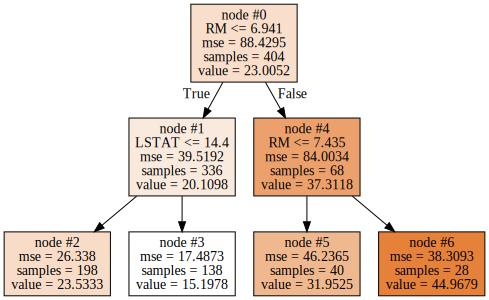

In [7]:
export_graphviz(model_tree, feature_names = boston.feature_names,
                filled = True, node_ids = True, out_file = 'tree.dot')

# read it in and visualize it, or if we wish to
# convert the .dot file into other formats, we can do:
# import os
# os.system('dot -Tpng tree1.dot -o tree1.jpeg')
with open('tree.dot') as f:
    dot_graph = f.read()

Source(dot_graph)

In [8]:
from sklearn.tree import _tree

# for instance we can see that
# node 0's (node 0 is the root node) 
# left children is node 1, so if we 
# do a search on the left children
node_id = 0
left_child = model_tree.tree_.children_left[node_id]
print('node {} left child {}'.format(node_id, left_child))

# and node 1 is a leaf node (no left or right children)
node_id = 1
left_child = model_tree.tree_.children_left[node_id]
print('node {} left child {}'.format(node_id, left_child))

# we can see that sklearn represents the leaf node using
# the number -1, and we'll use this information to obtain
# the decision tree path later
print('value for representing leaf node:', _tree.TREE_LEAF)

# we can confirm that the node count matches the total count
# that was shown on the decision tree graph above
print('total number of nodes:', model_tree.tree_.node_count)

node 0 left child 1
node 1 left child 2
value for representing leaf node: -1
total number of nodes: 7


The `.tree_` attribute provides the tree object of the DecisionTree model. Look up the docstring by doing `?model_tree.tree_`, it provides lots of useful documentation of information the tree object contains, which we'll be using in our implementation.

In [9]:
def _get_tree_paths(tree, node_id):
    """
    returns all paths through the tree as list
    of node_ids, note that the path here will
    be the sequence of nodes from the leaf node
    to the root node
    """
    left_node = tree.children_left[node_id]
    right_node = tree.children_right[node_id]

    if left_node != _tree.TREE_LEAF:
        left_paths = _get_tree_paths(tree, left_node)
        right_paths = _get_tree_paths(tree, right_node)

        for path in left_paths:
            path.append(node_id)

        for path in right_paths:
            path.append(node_id)

        paths = left_paths + right_paths
    else:
        paths = [[node_id]]
    
    # recursive algorithm can be unintuitive sometimes,
    # we can print the path to see the steps along the way
    # print(paths)
    return paths

In [10]:
paths = _get_tree_paths(tree = model_tree.tree_, node_id = 0)

# map leaves to paths,
# and reverse the path so
# that the sequence starts with the root node
leaf_to_path = {}
for path in paths:
    path.reverse()
    leaf_to_path[path[-1]] = path
    
leaf_to_path

{2: [0, 1, 2], 3: [0, 1, 3], 5: [0, 4, 5], 6: [0, 4, 6]}

In [11]:
def compute_contrib(model_tree, values, leaf_to_path):
    """
    compute the contribution vector for each unique tree leaf nodes
    and store the result into a dictionary, whose keys are leaf nodes
    and the corresponding value refers to the contribution vector of the leaf node.
    after that we can simply assign the contribution vector to each observation
    by looking up which leaf node it is assigned
    """
    # convert numpy array into python list,
    # accessing values will be faster
    # https://stackoverflow.com/questions/35020604/why-is-numpy-list-access-slower-than-vanilla-python
    values = list(values)

    # feature[i] holds the feature to split on,
    # for the internal node i
    feature = list(model_tree.tree_.feature)

    unique_contribs = {}
    for leaf, path in leaf_to_path.items():
        # compute the contribution of each feature
        # for a given observation
        contribs = np.zeros(model_tree.n_features_)
        for depth in range(len(path) - 1):
            contrib = values[path[depth + 1]] - values[path[depth]]
            feature_idx = feature[path[depth]]
            contribs[feature_idx] += contrib

        unique_contribs[leaf] = contribs

    return unique_contribs

In [12]:
# obtain the prediction value at each node,
# remove the single-dimensional inner arrays
values = model_tree.tree_.value.squeeze()

# the bias is always simply the value at the root node
bias = values[0]

unique_contribs = compute_contrib(model_tree, values, leaf_to_path)

# e.g. if the data point ends up in node 2,
# we can look up the contribution of each feature using:
unique_contribs[2]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -2.89537659,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  3.4235119 ])

In [13]:
# return the leaf index each data points ends up in
# and obtain prediction for each observation
# by using which leaf it belongs to;
# prediction is essentially the same as calling
# model_tree.predict(X) for regression tree
data_row = X_train[0]
X = np.atleast_2d(data_row)
leaf = model_tree.apply(X)[0]
prediction = values[leaf]
contrib = unique_contribs[leaf]

# convert the explanation to dataframe for better interpretation
value_col = 'value'
contrib_col = 'contrib'
feature_col = 'feature'
explained = {value_col: data_row,
             contrib_col: contrib,
             feature_col: feature_names}
df_explained = pd.DataFrame(explained, columns = [contrib_col, feature_col, value_col])
df_explained = (df_explained
                .loc[df_explained[contrib_col] != 0.0]
                .sort_values(contrib_col, ascending = False)
                .reset_index(drop = True))
df_explained

,contrib,feature,value
0,-2.895377,RM,5.782
1,-4.911995,LSTAT,15.940


In [14]:
bias + df_explained['contrib'].sum() == prediction

True

In [15]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size = 0.2, random_state = 14)

model_rf = RandomForestClassifier(max_depth = 6)
model_rf.fit(X_train, y_train)
accuracy_score(y_test, model_rf.predict(X_test))

0.96666666666666667

In [16]:
from tree_explainer import RandomForestExplainer

rf_explain = RandomForestExplainer(model_rf, iris.feature_names)
df_explained, pred_info = rf_explain.explain(X_train[0])

model_rf_pred = pred_info['predict']
bias = rf_explain.bias_[model_rf_pred]
model_rf_pred_proba = pred_info['predict_proba'][model_rf_pred]

print('bias:', bias)
print('predicted class:', model_rf_pred)
print('predicted proba:', model_rf_pred_proba)
actual_sum = bias + df_explained['contrib'].sum()
equal = np.allclose(actual_sum, model_rf_pred_proba)
print('bias + contribution = prediction:', equal)

df_explained

bias: 0.300833333333
predicted class:  0
predicted proba: 1.0
bias + contribution = prediction: True


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


,contrib,feature,value
0,0.406349,petal width (cm),0.2
1,0.177880,petal length (cm),1.5
2,0.114937,sepal length (cm),5.1
